## Dimension Reduction ##

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

In [32]:
df = pd.read_csv('Data/train_data.csv')
df = df.dropna()
df.head()

,id,date,prix,nb_chambres,nb_sdb,m2_interieur,m2_jardin,m2_etage,m2_soussol,nb_etages,...,vue_note,etat_note,design_note,annee_construction,annee_renovation,m2_interieur_15voisins,m2_jardin_15voisins,zipcode,lat,long
0,4443800785,2014-11-21T00:00:00Z,481000,2,1.00,150.501672,360.460795,85.470085,65.031587,1.0,...,0,4,7,1924,0,123.560015,360.460795,98117,47.6855,-122.391
1,2722059013,2015-02-04T00:00:00Z,550000,2,1.00,117.985879,4046.822742,117.985879,0.000000,1.0,...,0,4,5,1908,0,173.727239,646.599777,98042,47.3651,-122.165
2,8856004730,2014-09-17T00:00:00Z,199950,2,2.75,147.714604,1943.236715,147.714604,0.000000,1.5,...,0,3,5,1920,0,121.701970,557.413601,98001,47.2786,-122.250
3,2473003210,2015-03-13T00:00:00Z,364808,3,1.75,215.533259,731.605351,150.501672,65.031587,1.0,...,0,3,8,1967,0,184.875511,903.010033,98058,47.4524,-122.146
4,6743700335,2014-06-04T00:00:00Z,470000,3,2.00,167.224080,1176.978818,167.224080,0.000000,1.0,...,0,3,7,1956,1990,183.017466,908.119658,98033,47.6935,-122.173


In [39]:
X = df.drop(['id', 'vue_mer', 'annee_construction', 'annee_renovation', 'zipcode', 'lat', 'long', 'date','prix'], axis = 1)
y = df['prix']
X.mean()

nb_chambres                  3.371669
nb_sdb                       2.123010
m2_interieur               193.732114
m2_jardin                 1411.998121
m2_etage                   166.652667
m2_soussol                  27.079448
nb_etages                    1.497638
vue_note                     0.235376
etat_note                    3.409343
design_note                  7.668630
m2_interieur_15voisins     184.852674
m2_jardin_15voisins       1187.418834
dtype: float64

0.5957213660307991


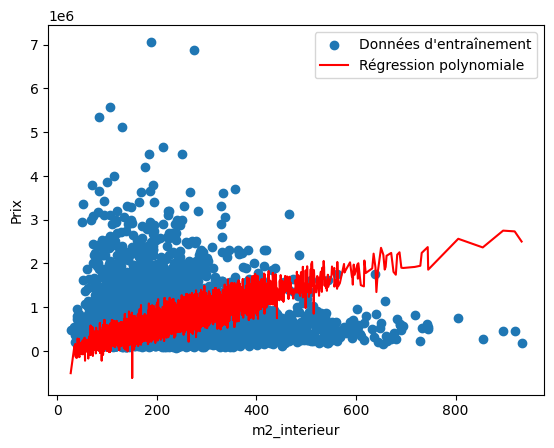

In [42]:
reg = LinearRegression().fit(X, y)
print(reg.score(X, y))
X.sort_values(by='m2_interieur', inplace=True)
y_pred = reg.predict(X)
plt.scatter(X['m2_interieur'], y, label='Données d\'entraînement')
#plt.scatter(X_test['m2_interieur'], y_test, label='Données de test')
plt.plot(X['m2_interieur'], y_pred, label='Régression polynomiale', color='red')
plt.xlabel('m2_interieur')
plt.ylabel('Prix')
plt.legend()
plt.show()

Score du modèle sur les données de test : 0.6842017071238831


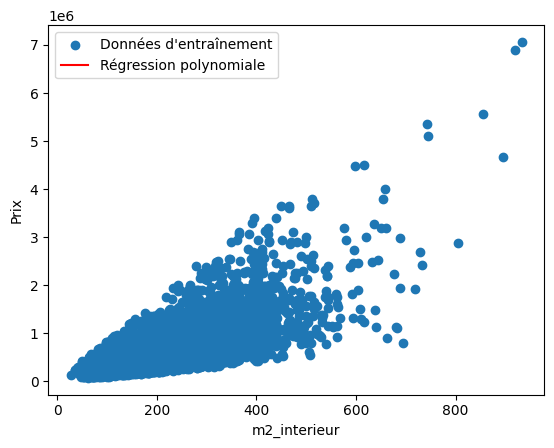

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer un pipeline pour transformer les variables indépendantes en un polynôme de degré 3 et ajuster le modèle linéaire
model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())

# Ajuster le modèle sur les données d'entraînement
model.fit(X_train, y_train)

# Évaluer le modèle sur les données de test
score = model.score(X_test, y_test)
print('Score du modèle sur les données de test :', score)

# Prédire les valeurs de y pour un ensemble de valeurs de x
X_new = pd.DataFrame(X.mean().values.reshape(1, -1), columns=X.columns)
X_new = pd.DataFrame(X_new, columns=X.columns)  # convertir X_new en DataFrame avec les mêmes colonnes que X
y_new = model.predict(X_new)

# Tracer les résultats
plt.scatter(X_train['m2_interieur'], y_train, label='Données d\'entraînement')
#plt.scatter(X_test['m2_interieur'], y_test, label='Données de test')
plt.plot(X_new['m2_interieur'], y_new, label='Régression polynomiale', color='red')
plt.xlabel('m2_interieur')
plt.ylabel('Prix')
plt.legend()
plt.show()
